In [97]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [98]:
import os
import json
import h5py
import urllib.request
import numpy as np
import pickle as pk
from IPython.display import Image, display, clear_output

In [99]:
from keras.models import Sequential, load_model
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import get_file
from keras.applications.vgg16 import VGG16
from keras.applications.imagenet_utils import preprocess_input, decode_predictions
from tensorflow.keras.utils import get_file
from tensorflow.keras.utils import load_img

In [100]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import array_to_img
from tensorflow.keras.preprocessing.image import img_to_array

In [101]:
model1 = VGG16(weights = 'imagenet')
model2 = load_model('/content/drive/MyDrive/DS_Project/Final_Dataset/augumentation_data_1/data_1/ft_model.h5')
model3 = load_model('/content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data2a/ft_model.h5')
model4 = load_model('/content/drive/MyDrive/DS_Project/Dataset/car-damage-dataset/data3a/ft_model.h5')

In [102]:
!pip install pickle5
import pickle5 as pk

In [103]:
with open('/content/drive/MyDrive/DS_Project/vgg16_cat_list.pk', 'rb') as f:
    cat_list = pk.load(f)


In [104]:
#Pipe 1: Check for car

CLASS_INDEX = None
CLASS_INDEX_PATH = 'https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json'

def get_predictions(preds, top=5):
    global CLASS_INDEX
    if len(preds.shape) != 2 or preds.shape[1] != 1000:
        raise ValueError('`decode_predictions` expects a batch of predictions (i.e. a 2D array of shape (samples, 1000)). Found array with shape: ' + str(preds.shape))
    if CLASS_INDEX is None:
        fpath = get_file('imagenet_class_index.json',CLASS_INDEX_PATH,cache_subdir='models')
        CLASS_INDEX = json.load(open(fpath))
    results = []
    for pred in preds:
        top_indices = pred.argsort()[-top:][::-1]
        result = [tuple(CLASS_INDEX[str(i)]) + (pred[i],) for i in top_indices]
        result.sort(key=lambda x: x[2], reverse=True)
        results.append(result)
    return results

In [105]:
def prepare_image_224(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg') # or other way to upload image
    img = load_img('save.jpg', target_size=(224, 224))
    x = img_to_array(img)
    x = np.expand_dims(x, axis=0)
    x = preprocess_input(x)
    return x

In [106]:
def pipe1(img_224, model):
    print("Ensuring entered picture is a car...")
    out = model.predict(img_224)
    preds = get_predictions(out, top=5)
    for pred in preds[0]:
        if pred[0:2] in cat_list:
            return True #"Successful. Proceeding to damage assessment..."
    return False #"The entered image is a not a car. Please try again. Consider a different angle or lighting."

In [107]:
#Pipe 2: Check for Damage

def prepare_img_256(img_path):
    urllib.request.urlretrieve(img_path, 'save.jpg')
    img = load_img('save.jpg', target_size=(256, 256))
    x = img_to_array(img)
    x = x.reshape((1,) + x.shape)/255
    return x

In [108]:
def pipe2(img_256, model):
    print("Validating if damage exists....")
    pred = model.predict(img_256)
    if(pred[0][0]<=0.5):
        return True #print("Validation complete - proceed to location and severity determination")
    else:
        return False
        #print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
        #print ("Hint: Try zooming in/out, using a different angle or different lighting")

In [109]:
def pipe3_loc(img_256, model):
    print("Determining location of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'FRONT', 1:'REAR', 2:'SIDE'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("LOCATION OF DAMAGE : {}".format(d[key]))
    print("Location assessment complete\n")

In [110]:
def pipe3_sev(img_256, model):
    print("Determining severity of damage...")
    pred = model.predict(img_256)
    pred_labels = np.argmax(pred, axis=1)
    d = {0:'MINOR', 1:'MODERATE', 2:'SEVERE'}
    for key in d.keys():
        if pred_labels[0] == key:
            print("SEVERITY OF DAMAGE : {}".format(d[key]))
    print("Severity assessment complete.")

In [111]:
#Complete Pipeline

def pipeline(img_path):
    while True:
        #print("Submit image link (or type 'exit' to quit)")
        #img_path = input("Upload Image File Here:")
        #if img_path == 'exit':
        #    return None
        #clear_output()
        img_224 = prepare_image_224(img_path)
        p1 = pipe1(img_224, model1)
        display(Image('save.jpg', width=300))
        if p1 is False:
            print("CAR NOT DETECTED!! Please try again. ")
            break
        else:
            print("CAR DETECTED!! Proceeding to damage assessment...\n")

        img_256 = prepare_img_256(img_path)
        p2 = pipe2(img_256, model2)

        if p2 is False:
            print ("Are you sure that your car is damaged? Please submit another picture of the damage.")
            print ("Hint: Try zooming in/out, using a different angle or different lighting")
            break
        else:
            print("Validation complete - proceed to location and severity determination\n")

        x = pipe3_loc(img_256, model3)
        y = pipe3_sev(img_256, model4)
        break

Ensuring entered picture is a car...
1/1 [==============================] - 1s 840ms/step


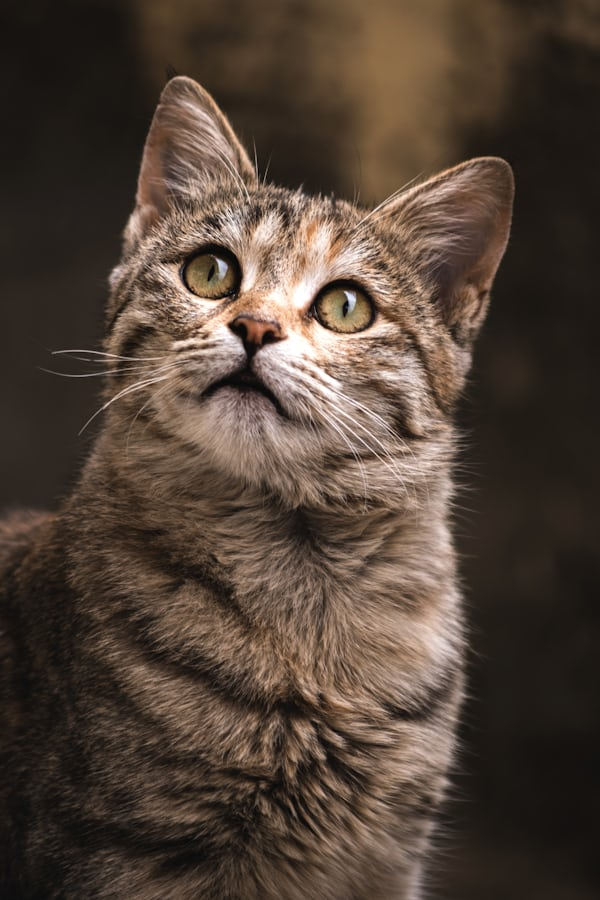

CAR NOT DETECTED!! Please try again. 


In [112]:
pipeline('https://images.unsplash.com/photo-1608848461950-0fe51dfc41cb?w=600&auto=format&fit=crop&q=60&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxleHBsb3JlLWZlZWR8MXx8fGVufDB8fHx8fA%3D%3D')

Ensuring entered picture is a car...
1/1 [==============================] - 0s 400ms/step


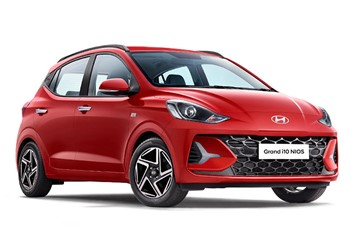

CAR DETECTED!! Proceeding to damage assessment...

Validating if damage exists....
1/1 [==============================] - 1s 703ms/step
Are you sure that your car is damaged? Please submit another picture of the damage.
Hint: Try zooming in/out, using a different angle or different lighting


In [113]:
pipeline('https://cdni.autocarindia.com/utils/imageresizer.ashx?n=https://cms.haymarketindia.net/model/uploads/modelimages/Hyundai-Grand-i10-Nios-200120231541.jpg&w=350&h=251&q=91&c=1')

Ensuring entered picture is a car...
1/1 [==============================] - 0s 390ms/step


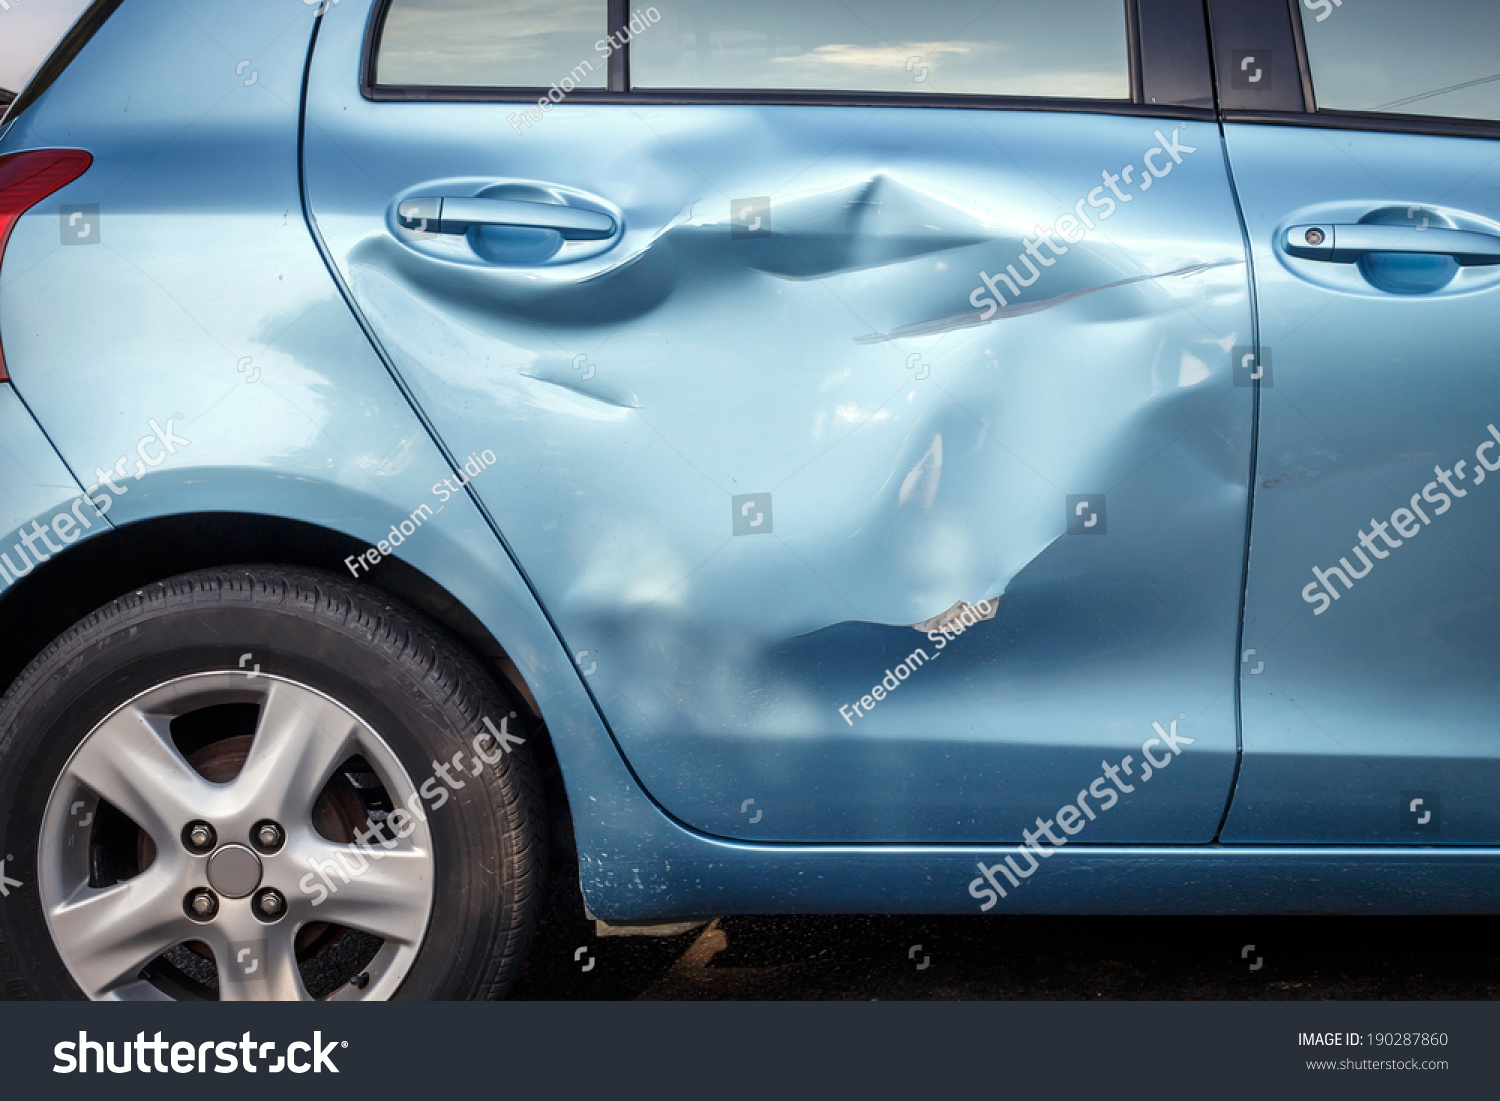

CAR DETECTED!! Proceeding to damage assessment...

Validating if damage exists....
1/1 [==============================] - 0s 473ms/step
Validation complete - proceed to location and severity determination

Determining location of damage...
1/1 [==============================] - 1s 710ms/step
LOCATION OF DAMAGE : SIDE
Location assessment complete

Determining severity of damage...
1/1 [==============================] - 1s 583ms/step
SEVERITY OF DAMAGE : MODERATE
Severity assessment complete.


In [114]:
pipeline('https://www.shutterstock.com/shutterstock/photos/190287860/display_1500/stock-photo-body-of-car-get-damaged-by-accident-190287860.jpg')

Ensuring entered picture is a car...
1/1 [==============================] - 0s 446ms/step


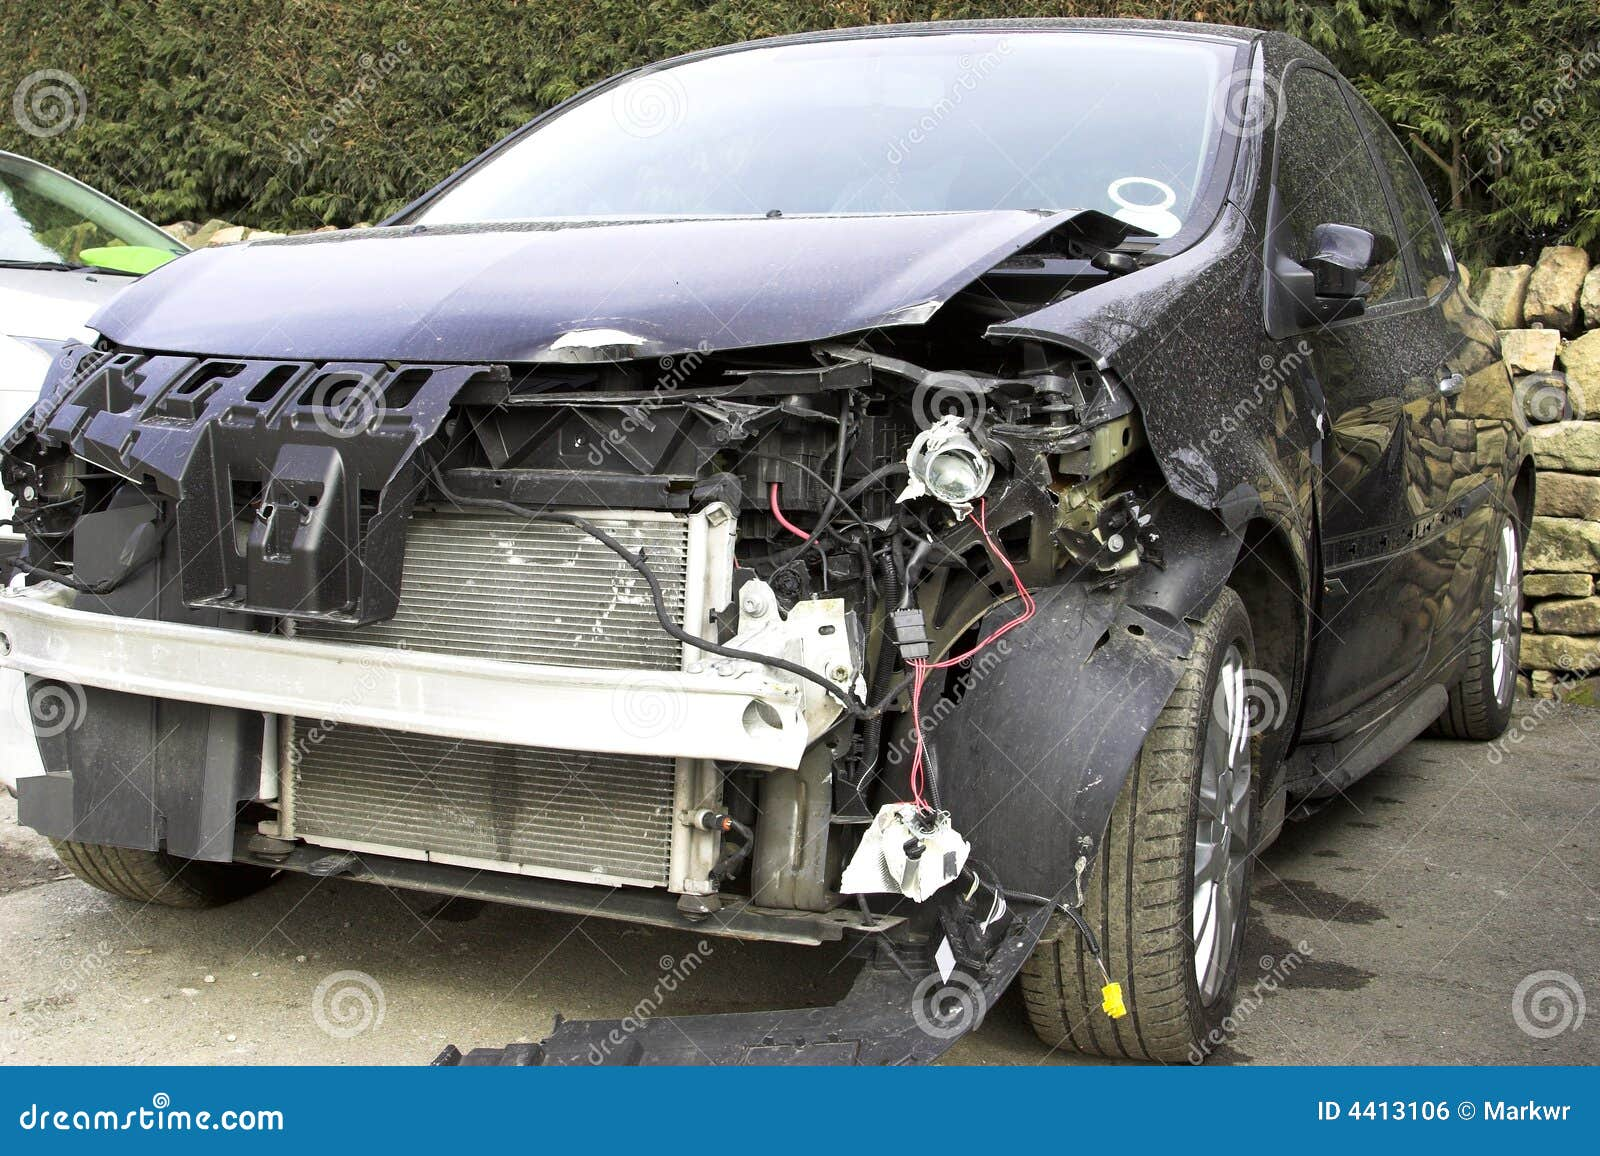

CAR DETECTED!! Proceeding to damage assessment...

Validating if damage exists....
1/1 [==============================] - 1s 641ms/step
Validation complete - proceed to location and severity determination

Determining location of damage...
1/1 [==============================] - 1s 659ms/step
LOCATION OF DAMAGE : FRONT
Location assessment complete

Determining severity of damage...
1/1 [==============================] - 1s 545ms/step
SEVERITY OF DAMAGE : SEVERE
Severity assessment complete.


In [115]:
pipeline('https://thumbs.dreamstime.com/z/accident-damaged-vehicle-4413106.jpg')

Ensuring entered picture is a car...
1/1 [==============================] - 0s 401ms/step


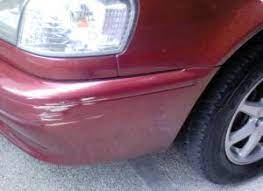

CAR DETECTED!! Proceeding to damage assessment...

Validating if damage exists....
1/1 [==============================] - 1s 778ms/step
Validation complete - proceed to location and severity determination

Determining location of damage...
1/1 [==============================] - 1s 661ms/step
LOCATION OF DAMAGE : REAR
Location assessment complete

Determining severity of damage...
1/1 [==============================] - 1s 833ms/step
SEVERITY OF DAMAGE : MINOR
Severity assessment complete.


In [116]:
pipeline('https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTAWFgj6xctNM_s2R1YVc8KFgwwpt_bjFvOzAbkJ3L4RpKjJg-rYRPFdlhfO8G42bL61Mc&usqp=CAU')